In [ ]:
# Install this package to use Colab's GPU for training
!apt install --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be DOWNGRADED:
  libcudnn8
0 upgraded, 0 newly installed, 1 downgraded, 1 to remove and 22 not upgraded.
Need to get 420 MB of archives.
After this operation, 1,383 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  libcudnn8 8.4.1.50-1+cuda11.6 [420 MB]
Fetched 420 MB in 7s (58.1 MB/s)
(Reading database ... 122349 files and directories currently installed.)
Removing libcudnn8-dev (8.7.0.84-1+cuda11.8) ...
update-alternatives: removing manually selected alternative - switching libcudnn to auto mode
dpkg: warning: downgrading libcudnn8 from 8.7.0.84-1+cuda11.8 to 8.4.1.50-1+cuda11.6
(Reading database ... 122316 files and directories currently installed.)
Preparing to unpack .../libcudnn8_8.4.1.5

In [ ]:
import os
import glob
import shutil
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras.preprocessing import image
from tensorflow.keras.optimizers import Adam, SGD


In [ ]:
print(tf. __version__)

2.12.0


# Dataset
We need to connect drive to get access to the dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We need to extract contents of dataset

In [ ]:
local_zip = '/content/drive/MyDrive/UCMerced_LandUse (1).zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/drive/MyDrive/training')

In [ ]:
base_dir = os.path.join('/content/drive/MyDrive/training',  'UCMerced_LandUse', 'Images')
base_dir

'/content/drive/MyDrive/training/UCMerced_LandUse/Images'

The dataset we downloaded contains different types of images:

Rose

*   agricultural
*   airplane
*   baseballdiamond
*   beach
*   buildings
*   chaparral
*   denseresidential
*   forest
*   freeway
*   golfcourse
*   harbor
*   intersection
*   mediumresidental
*   mobilehomepark
*   overpass
*parkinglot
*   river
*   runway
*   sparseresidental
*   storagetanks
*   tenniscourt

So, let's create the labels for these 5 classes:




In [ ]:
classes = ['agricultural',
'airplane',
'baseballdiamond',
'beach',
'buildings',
'chaparral',
'denseresidential',
'forest',
'freeway',
'golfcourse',
'harbor',
'intersection',
'mediumresidential',
'mobilehomepark',
'overpass',
'parkinglot',
'river',
'runway',
'sparseresidential',
'storagetanks',
'tenniscourt']

print(len(classes))

21


As you can see there are no folders containing training and validation data. Therefore, we will have to create our own training and validation set. Let's write some code that will do this.

The code below creates a train and a val folder each containing 20 folders (one for each type of image). It then moves the images from the original folders to these new folders such that 80% of the images go to the training set and 20% of the images go into the validation set. In the end our directory will have the following structure:

Since we don't delete the original folders, they will still be in our Images directory, but they will be empty. The code below also prints the total number of different images we have for each type of class.

In [ ]:
for cl in classes:
    print(f"There are {len(os.listdir(os.path.join(base_dir, cl)))} images of {cl} category.\n")

There are 100 images of agricultural category.

There are 100 images of airplane category.

There are 100 images of baseballdiamond category.

There are 100 images of beach category.

There are 100 images of buildings category.

There are 100 images of chaparral category.

There are 100 images of denseresidential category.

There are 100 images of forest category.

There are 100 images of freeway category.

There are 100 images of golfcourse category.

There are 100 images of harbor category.

There are 100 images of intersection category.

There are 100 images of mediumresidential category.

There are 100 images of mobilehomepark category.

There are 100 images of overpass category.

There are 100 images of parkinglot category.

There are 100 images of river category.

There are 100 images of runway category.

There are 100 images of sparseresidential category.

There are 100 images of storagetanks category.

There are 100 images of tenniscourt category.



In [ ]:
for cl in classes:
    img_path = os.path.join(base_dir, cl)
    images = glob.glob(img_path + '/*.tif')
    #print("{}: {} Images".format(cl, len(images)))
    train, val, test = images[:round(len(images)*0.80)], images[round(len(images)*0.80):round(len(images)*0.90)], images[round(len(images)*0.90):]

    for t in train:
        if not os.path.exists(os.path.join(base_dir, 'train', cl)):
            os.makedirs(os.path.join(base_dir, 'train', cl))
        try:   
            shutil.move(t, os.path.join(base_dir, 'train', cl))
        except:
            continue

    for v in val:
        if not os.path.exists(os.path.join(base_dir, 'val', cl)):
            os.makedirs(os.path.join(base_dir, 'val', cl))
        try:
            shutil.move(v, os.path.join(base_dir, 'val', cl))
        except:
            continue

    for t in test:
        if not os.path.exists(os.path.join(base_dir, 'test', cl)):
            os.makedirs(os.path.join(base_dir, 'test', cl))
        try:   
            shutil.move(t, os.path.join(base_dir, 'test', cl))
        except:
            continue

In [ ]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Data Augmentation
Overfitting generally occurs when we have small number of training examples. One way to fix this problem is to augment our dataset so that it has sufficient number of training examples. Data augmentation takes the approach of generating more training data from existing training samples, by augmenting the samples via a number of random transformations that yield believable-looking images. The goal is that at training time, your model will never see the exact same picture twice. This helps expose the model to more aspects of the data and generalize better.

In tf.keras we can implement this using the same ImageDataGenerator class we used before. We can simply pass different transformations we would want to our dataset as a form of arguments and it will take care of applying it to the dataset during our training process.

## Set Batch and Image Size
In the cell below, create a batch_size of 32 images and set a value to IMG_SHAPE such that our training data consists of images with width of 256 pixels and height of 256 pixels.

In [ ]:
batch_size = 32 # Number of training examples to process before updating our models variables
IMG_SHAPE = 256  # Our training data consists of images with width of 256 pixels and height of 256 pixels

## Create Training and Validation Generators and apply different transformations to images

In [ ]:
# train_val_generators
# Instantiate the ImageDataGenerator class 
# Normalize pixel values and set arguments to augment the images 
train_datagen = ImageDataGenerator(rescale=1./255.,
                                     horizontal_flip=True,
                                     fill_mode='nearest',
                                     zoom_range=0.2,
                                     rotation_range = 40,
                                     shear_range = 0.2)

# Pass in the appropriate arguments to the flow_from_directory method
train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                      shuffle = True,
                                                      batch_size=32, 
                                                      class_mode='sparse',
                                                      target_size=(IMG_SHAPE, IMG_SHAPE))
# Validation data should not be augmented
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(batch_size=batch_size,
                                                 directory=val_dir,
                                                 class_mode='sparse',
                                                 target_size=(IMG_SHAPE, IMG_SHAPE))
# Test data should not be augmented
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(batch_size=batch_size,
                                                 directory=test_dir,
                                                 class_mode='sparse',
                                                 target_size=(IMG_SHAPE, IMG_SHAPE))


Found 1785 images belonging to 21 classes.
Found 420 images belonging to 21 classes.
Found 210 images belonging to 21 classes.


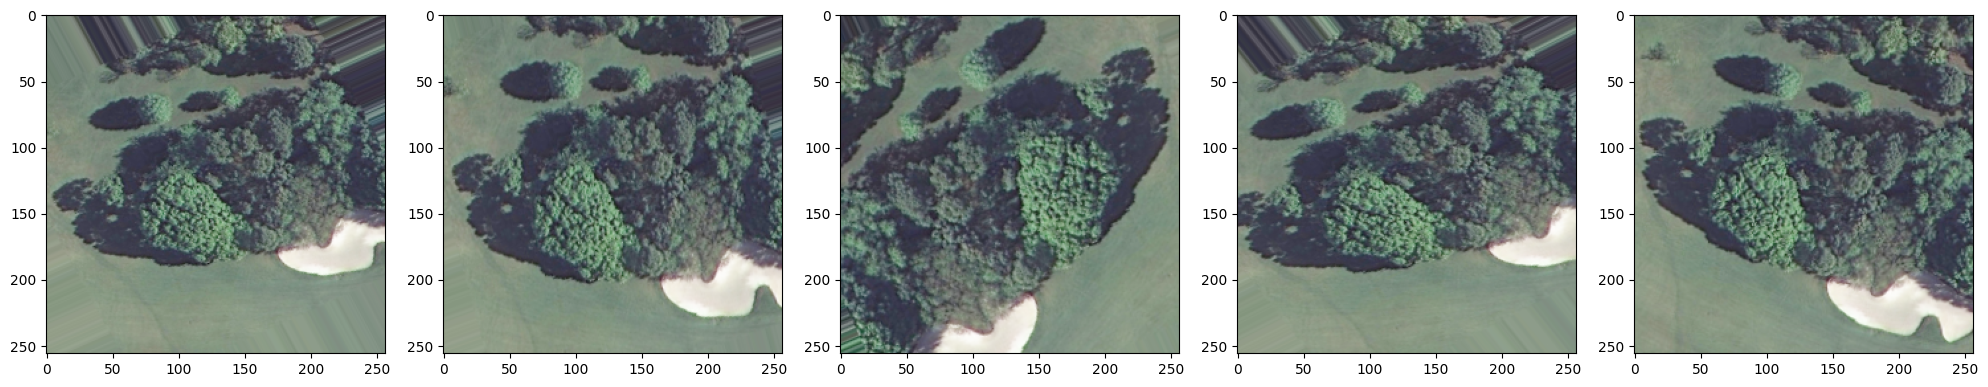

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

# Create the CNN
In the cell below, we create a convolutional neural network that consists of 3 convolution blocks. Each convolutional block contains a Conv2D layer followed by a max pool layer.
The CNN should output class probabilities based on 21 classes which is done by the softmax activation function. All other layers should use a relu activation function.

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(256,256,3)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(21)
])
     

# Compile the Model
In the cell below, compile our model using the ADAM optimizer, the sparse cross entropy function as a loss function. We would also like to look at training and validation accuracy on each epoch as we train our network, so we also pass the metrics argument.

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
     

In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 30, 30, 32)      

# Train the Model
In the cell below, we train our model using the fit_generator function instead of the usual fit function. We have to use the fit_generator function because we are using the ImageDataGenerator class to generate batches of training and validation data for our model. We train the model for 80 epochs and  use the proper parameters in the fit_generator function.

In [ ]:
epochs = 25

history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

<ipython-input-127-89e55819704e>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/25
56/56 [==============================] - 39s 619ms/step - loss: 2.8396 - accuracy: 0.1283 - val_loss: 2.9442 - val_accuracy: 0.1905
Epoch 2/25
56/56 [==============================] - 35s 618ms/step - loss: 2.3231 - accuracy: 0.2790 - val_loss: 2.0916 - val_accuracy: 0.3016
Epoch 3/25
56/56 [==============================] - 34s 606ms/step - loss: 1.9947 - accuracy: 0.3546 - val_loss: 2.0875 - val_accuracy: 0.3270
Epoch 4/25
56/56 [==============================] - 34s 616ms/step - loss: 1.6827 - accuracy: 0.4465 - val_loss: 1.9045 - val_accuracy: 0.3937
Epoch 5/25
56/56 [==============================] - 35s 615ms/step - loss: 1.4292 - accuracy: 0.5333 - val_loss: 1.8385 - val_accuracy: 0.4286
Epoch 6/25
56/56 [==============================] - 34s 609ms/step - loss: 1.2814 - accuracy: 0.5838 - val_loss: 1.9950 - val_accuracy: 0.3968
Epoch 7/25
56/56 [==============================] - 35s 622ms/step - loss: 1.1583 - accuracy: 0.6308 - val_loss: 1.5281 - val_accuracy: 0.5556

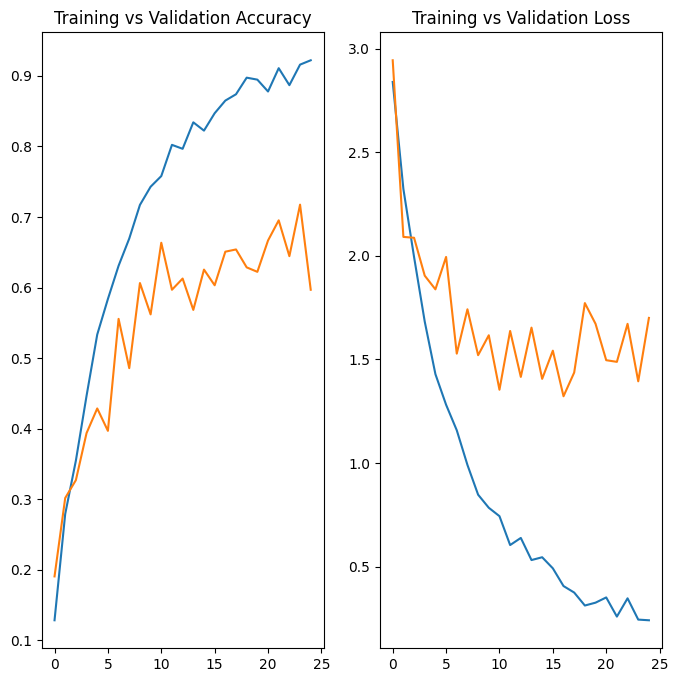

In [ ]:
train_acc =  history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, train_acc, label='Training accuracy')
plt.plot(epochs_range, val_acc, label='Validation accuracy')
plt.title('Training vs Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, train_loss, label='Training loss')
plt.plot(epochs_range, val_loss, label='Validation loss')
plt.title('Training vs Validation Loss')

plt.show()

In [ ]:
mymodel = model.save('model_v1.h5')

# Perform Transfer Learning with the Inception Model

TensorFlow Hub is an online repository of already trained TensorFlow models that you can use. These models can either be used as is, or they can be used for Transfer Learning.

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255.,
                                     horizontal_flip=True,
                                     fill_mode='nearest',
                                     zoom_range=0.2,
                                     rotation_range = 40,
                                     width_shift_range = 0.2,
                                     height_shift_range = 0.2,
                                     shear_range = 0.2)

  # Pass in the appropriate arguments to the flow_from_directory method
train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                      batch_size=32, 
                                                      class_mode='sparse',
                                                      target_size=(150, 150))

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  # Remember that validation data should not be augmented
validation_datagen = ImageDataGenerator(rescale=1./255.)

  # Pass in the appropriate arguments to the flow_from_directory method
validation_generator = validation_datagen.flow_from_directory(directory=val_dir,
                                                                batch_size=32, 
                                                                class_mode='sparse',
                                                                target_size=(150, 150))

Found 1785 images belonging to 21 classes.
Found 315 images belonging to 21 classes.


In [ ]:
import tensorflow_hub as hub

In [ ]:
URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor = hub.KerasLayer(URL, 
                                   input_shape=(150, 150, 3))
feature_extractor.trainable = False
model_inception = tf.keras.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(21)
])

model_inception.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 21)                43029     
                                                                 
Total params: 21,845,813
Trainable params: 43,029
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

In [ ]:
model_inception.compile(
  optimizer='adam', 
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 1

callbacks = myCallback()
history = model_inception.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = EPOCHS,
                    callbacks=callbacks)

NameError: ignored

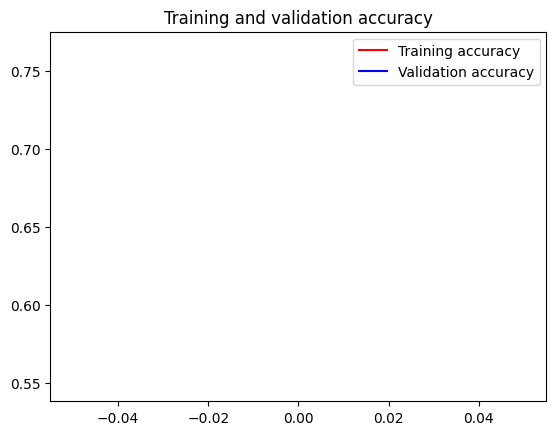

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot the training and validation accuracies for each epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
loss, accuracy = model_inception.evaluate_generator(test_generator)

<ipython-input-19-565a80a791a5>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, accuracy = model_inception.evaluate_generator(test_generator)


In [ ]:
loss, accuracy

(1.0260050296783447, 0.7476190328598022)

# Save model

In [ ]:
model_inception = model_inception.save('model_inception.h5',include_optimizer=True )

# Check the model for predictions

In [ ]:
model_inception = tf.keras.models.load_model('model_inception.h5',custom_objects={'KerasLayer':hub.KerasLayer})

In [ ]:
def format_image(image, IMAGE_RES):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))
  image = image/255.0
  return image

Saving 640px-Ryanair.arp.750pix.jpg to 640px-Ryanair.arp.750pix (12).jpg
1/1 [==============================] - 0s 30ms/step
640px-Ryanair.arp.750pix.jpg
Predicted class: airplane, Predicted index: 1
Probability: 78.50%


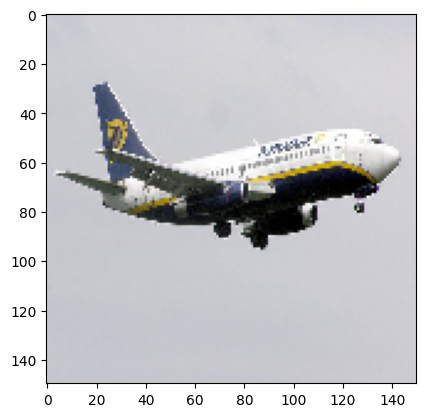

In [ ]:
from google.colab import files

uploaded = files.upload()
for fn in uploaded.keys():
    path = fn
    img = tf.keras.utils.load_img(path, target_size=(150, 150))
    x = tf.keras.utils.img_to_array(img)
    x = format_image(x, 150)
    plt.imshow(x)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    logits = model_inception.predict(images)
    probs = tf.nn.softmax(logits)

    # Get the predicted class with the highest probability
    pred_index = np.argmax(probs)
    #As index starts from zero, add 1 to index to identify class
    pred_class = pred_index+1
    # Print the predicted class and its probability
    print(fn)
    print(f"Predicted class: {classes[pred_index]}, Predicted index: {pred_index}")
    print(f"Probability: {probs[0][pred_index] * 100:.2f}%")


In [ ]:
# assuming y_true and y_pred are tensors containing the true and predicted labels, respectively
f1 = tf.keras.metrics.F1Score(num_classes=21, average='weighted')
f1.update_state(y_true, y_pred)
f1_result = f1.result().numpy()
print('F1 score:', f1_result)

# MobileNet v2 model

Create new image generators because MobileNet requires (224,224) size of images.

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255.,
                                     horizontal_flip=True,
                                     fill_mode='nearest',
                                     zoom_range=0.2,
                                     rotation_range = 40,
                                     width_shift_range = 0.2,
                                     height_shift_range = 0.2,
                                     shear_range = 0.2)

  # Pass in the appropriate arguments to the flow_from_directory method
train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                      batch_size=32, 
                                                      class_mode='sparse',
                                                      target_size=(224,224))

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  # Remember that validation data should not be augmented
validation_datagen = ImageDataGenerator(rescale=1./255.)

  # Pass in the appropriate arguments to the flow_from_directory method
validation_generator = validation_datagen.flow_from_directory(directory=val_dir,
                                                                batch_size=32, 
                                                                class_mode='sparse',
                                                                target_size=(224,224))

# Test data should not be augmented
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(batch_size=batch_size,
                                                  shuffle=False,
                                                 directory=test_dir,
                                                 class_mode='sparse',
                                                 target_size=(224,224))

Found 1785 images belonging to 21 classes.
Found 588 images belonging to 21 classes.
Found 399 images belonging to 21 classes.


In the cell below we create a feature_extractor using MobileNet v2. The partial model from TensorFlow Hub (without the final classification layer) is called a feature vector. Finally, we will create a feature_extractor by using hub.KerasLayer with the correct input_shape parameter.

In [ ]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL, input_shape=(224, 224, 3))

## Freeze the Pre-Trained Model

In [ ]:
feature_extractor.trainable = False

### Attach a classification head

In [ ]:
model_mobile = tf.keras.Sequential([feature_extractor,
                            layers.Dense(21)])
model_mobile.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense_1 (Dense)             (None, 21)                26901     
                                                                 
Total params: 2,284,885
Trainable params: 26,901
Non-trainable params: 2,257,984
_________________________________________________________________


## Train the model

In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 19.7 MB/s eta 0:00:00


In [ ]:
import tensorflow_addons as tfa


/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
model_mobile.compile(optimizer='SGD',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
EPOCHS = 10

history = model_mobile.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = EPOCHS)

Epoch 1/10
56/56 [==============================] - 124s 2s/step - loss: 0.7830 - accuracy: 0.8224 - val_loss: 0.8197 - val_accuracy: 0.8010
Epoch 2/10
56/56 [==============================] - 124s 2s/step - loss: 0.6456 - accuracy: 0.8521 - val_loss: 0.6846 - val_accuracy: 0.8384
Epoch 3/10
56/56 [==============================] - 144s 3s/step - loss: 0.5306 - accuracy: 0.8807 - val_loss: 0.6141 - val_accuracy: 0.8537
Epoch 4/10
56/56 [==============================] - 141s 3s/step - loss: 0.4658 - accuracy: 0.8992 - val_loss: 0.5613 - val_accuracy: 0.8707
Epoch 5/10
56/56 [==============================] - 139s 2s/step - loss: 0.4268 - accuracy: 0.9031 - val_loss: 0.5213 - val_accuracy: 0.8741
Epoch 6/10
56/56 [==============================] - 140s 2s/step - loss: 0.3821 - accuracy: 0.9188 - val_loss: 0.4826 - val_accuracy: 0.8810
Epoch 7/10
56/56 [==============================] - 138s 2s/step - loss: 0.3534 - accuracy: 0.9188 - val_loss: 0.4695 - val_accuracy: 0.8878
Epoch 8/10
56

In [ ]:
loss, accuracy = model_mobile.evaluate_generator(test_generator)
loss, accuracy

<ipython-input-74-6de5efcc4dfa>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, accuracy = model_mobile.evaluate_generator(test_generator)


(0.48225414752960205, 0.8796992301940918)

## F1 score

In [ ]:
from sklearn.metrics import f1_score

# Get predictions for the test set
y_pred = model_mobile.predict(test_generator)

# Calculate the F1 score
y_true = test_generator.classes
y_pred = np.argmax(y_pred, axis=1)
f1score = f1_score(y_true, y_pred, average='weighted')
print('F1 score:', f1score)

13/13 [==============================] - 19s 1s/step
F1 score: 0.8787070119181687


In [ ]:
y_true, y_pred

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,
         7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
         9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 

Saving 640px-Ryanair.arp.750pix.jpg to 640px-Ryanair.arp.750pix (4).jpg
1/1 [==============================] - 0s 70ms/step
640px-Ryanair.arp.750pix.jpg
Predicted class: airplane, Predicted index: 1
Probability: 78.09%


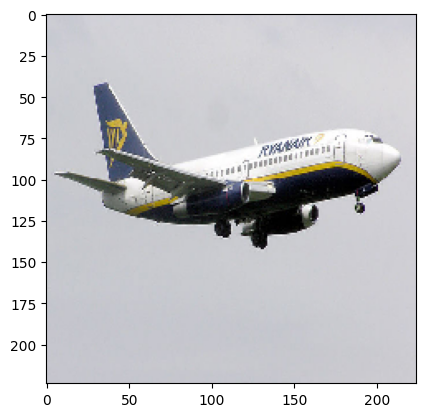

In [ ]:
from google.colab import files

uploaded = files.upload()
for fn in uploaded.keys():
    path = fn
    img = tf.keras.utils.load_img(path, target_size=(224,224))
    x = tf.keras.utils.img_to_array(img)
    x = format_image(x, 224)
    plt.imshow(x)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    logits = model_mobile.predict(images)
    probs = tf.nn.softmax(logits)

    # Get the predicted class with the highest probability
    pred_index = np.argmax(probs)
    #As index starts from zero, add 1 to index to identify class
    pred_class = pred_index+1
    # Print the predicted class and its probability
    print(fn)
    print(f"Predicted class: {classes[pred_index]}, Predicted index: {pred_index}")
    print(f"Probability: {probs[0][pred_index] * 100:.2f}%")


## Plot Training and Validation Graphs

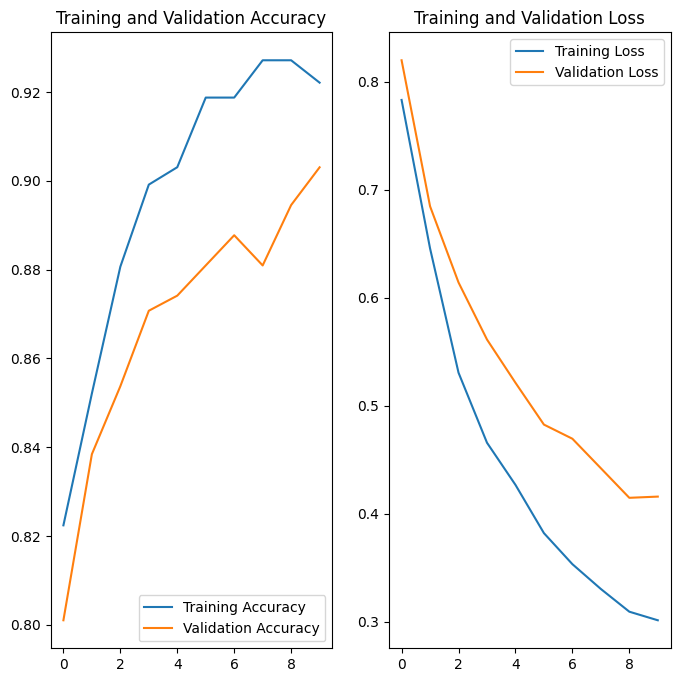

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Save model

In [ ]:
model_mobile = model_mobile.save('model_mobile.h5',include_optimizer=True )